In [1]:
!pip install -q chromadb
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q transformers
!pip install -q langchain
!pip install -q sentence_transformers
!pip install -q unstructured
!pip install -q bitsandbytes
!pip install -q accelerate
!pip install -U -q langchain-community
!pip install -q matplotlib
!pip install -q pandas

In [8]:
!transformers-cli env


Copy-and-paste the text below in your GitHub issue and FILL OUT the two last points.

- `transformers` version: 4.41.2
- Platform: Windows-10-10.0.22621-SP0
- Python version: 3.11.9
- Huggingface_hub version: 0.23.2
- Safetensors version: 0.4.3
- Accelerate version: 0.30.1
- Accelerate config: 	not found
- PyTorch version (GPU?): 2.3.0+cu121 (True)
- Tensorflow version (GPU?): not installed (NA)
- Flax version (CPU?/GPU?/TPU?): not installed (NA)
- Jax version: not installed
- JaxLib version: not installed
- Using GPU in script?: <fill in>
- Using distributed or parallel set-up in script?: <fill in>



In [2]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#################################################################
# Tokenizer
#################################################################

model_name='meta-llama/Meta-Llama-3-8B-Instruct'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\201902452\.cache\huggingface\hub\models--meta-llama--Meta-Llama-3-8B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Special tokens have been added in the vocabulary, make sure the as

In [6]:
#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "bfloat16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

# Device partition
device_map = "auto"

In [7]:
#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [8]:
#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    low_cpu_mem_usage = True,
    device_map = "auto"
)

Trying to resume download...
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


## LangChain

In [9]:
CHROMA_PATH = "chroma" # Where to store the database
DATA_PATH = "data" # Path to the documents

In [10]:
from bs4 import BeautifulSoup
import os

# Load all the documents in a dictionary and add XML tags as fields inside the dictionary
def XMLLoader(folder_path):
    reportData_list = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                content = file.read()

            soup = BeautifulSoup(content, 'xml')

            reportData = {}
            for tag in soup.find_all():
                if tag.name != "report":
                    reportData[tag.name] = tag.text.strip()

            reportData["filename"] = filename
            reportData_list.append(reportData)

    return reportData_list

In [11]:
data =  XMLLoader("data")

In [12]:
from langchain.docstore.document import Document

# Create a "Document" class from LangChain and add all the tags as document metadata
documents = []
for doc in data:

    document = Document(page_content=doc["report_text"], metadata={"source": doc["filename"],
                                                                   "subtype": doc["subtype"],
                                                                   "type": doc["type"],
                                                                   "chief_complaint": doc["chief_complaint"],
                                                                   "admit_diagnosis": doc["admit_diagnosis"],
                                                                   "discharge_diagnosis": doc["discharge_diagnosis"],
                                                                   "year": doc["year"],
                                                                   "downlaod_time": doc.get("download_time", ""), # Algunos no tiemem este campo
                                                                   "deid": doc["deid"]})
    documents.append(document)

In [13]:
print(documents[5])

page_content="[Report de-identified (Safe-harbor compliant) by De-ID v.6.22.06.0]\n\n\n \n**INSTITUTION\nEMERGENCY DEPARTMENT\nPATIENT NAME:  **NAME[AAA, BBB M]\nACCOUNT #:  **ID-NUM \nDATE OF SERVICE:  **DATE[Mar 02 06] \nPRIMARY CARE PHYSICIAN: **NAME[QQQ M PPP]\nHISTORY OF PRESENT ILLNESS:  \nCHIEF COMPLAINT:  Intracerebral hemorrhage.\nI evaluated this patient with the resident physician, Dr.   **NAME[OOO NNN].  We \ndiscussed the history, physical and plan.  I concur with his findings.  I \nalso interviewed and examined the patient myself.  I reviewed all the \npertinent nursing notes as well as predictation resident notes for this \npatient.  I concur with the content.  \nThe patient is an intubated sedated, **AGE[in 70s]-year-old man who comes from an \noutside facility with the diagnosis of right intraparenchymal hemorrhage in \nthe basal ganglia thalamus region.  The patient was intubated and could not \ngive any other history, but prior to being intubated did give the history

### Load embedding model

In [15]:
from langchain.vectorstores.chroma import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from sentence_transformers import SentenceTransformer
import shutil

embedding_model = "BAAI/bge-small-en-v1.5"

# Clear out the database first if already exists.
if os.path.exists(CHROMA_PATH):
    shutil.rmtree(CHROMA_PATH)

# https://huggingface.co/sentence-transformers
# https://huggingface.co/spaces/mteb/leaderboard
embeddings = SentenceTransformerEmbeddings(model_name=embedding_model)

print(f"Model's max seq length: {SentenceTransformer('BAAI/bge-small-en-v1.5').max_seq_length}")

# Para determinar el tamaño de los chunks
# Embedding dimensions: 384 (Dimensión de los embeddings en el espacio vectorial)
# Max tokens: 512 (Max tokens que le puedes meter al modelo de embeddings)


C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\201902452\.cache\huggingface\hub\models--BAAI--bge-small-en-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS

Model's max seq length: 512


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_docs_tokens(docs_processed, name):
  tokenizer = AutoTokenizer.from_pretrained(embedding_model)
  lengths = [
      len(tokenizer.encode(doc.page_content))
      for doc in docs_processed
  ]

  fig = pd.Series(lengths).hist()
  plt.xlabel("Número de tokens")
  plt.ylabel("Número de chunks")
  plt.savefig(name)
  plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (1776 > 512). Running this sequence through the model will result in indexing errors


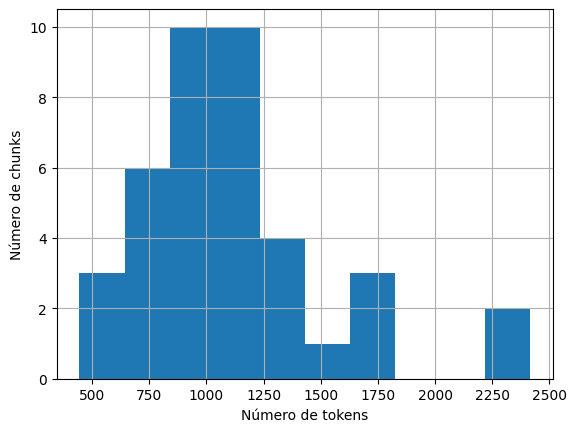

In [57]:
plot_docs_tokens(documents, "noChunkLimit.png")

En el eje X la cantidad de tokens y en el eje y la cantidad de chunks con esos tokens.

### Text split

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

chunk_size = 500

# LLama3 - Ventana de contexto de 8000 tokens
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=chunk_size,
    chunk_overlap=int(chunk_size / 10),
    add_start_index=True
)

chunks = text_splitter.split_documents(documents)
print(f"Split {len(documents)} documents into {len(chunks)} chunks.")

Split 41 documents into 187 chunks.


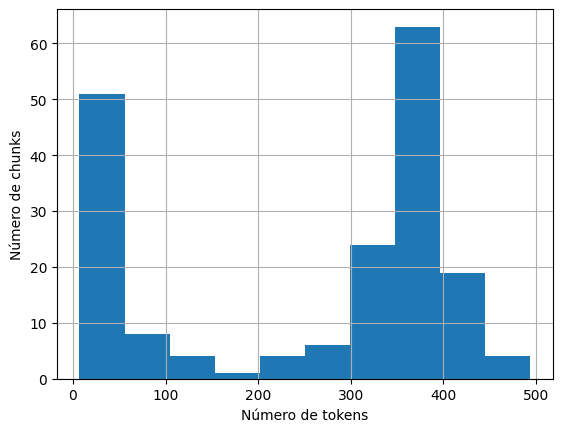

In [58]:
plot_docs_tokens(chunks, "ChunkLimit.png")

In [17]:
# Create a new DB from the documents.
db = Chroma.from_documents(
    chunks,
    embeddings,
    persist_directory=CHROMA_PATH
)

print(f"Saved {len(chunks)} chunks to {CHROMA_PATH}.")

# Cogemos un chunk aleatorio
document = chunks[10]
print(document.page_content) # Printeamos su contenido
print(document.metadata) # Y su metadata (Fichero al que pertenece y donde empieza 'start_index')

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Saved 187 chunks to chroma.
Normal __________.  No erythema or exudate.  The neck is supple.  
Cardiovascular - Regular rate and rhythm.  No murmurs, rubs, or gallops.  
Respiratory - Good breath sounds throughout.  No crackles or wheezes.  
Abdomen - Positive bowel sounds.  Soft, nondistended.  There is some slight 
tenderness to palpation diffusely.  No percussion tenderness present.  
Musculoskeletal - Pulses 2+ bilaterally.  No clubbing, cyanosis, or edema.  
Neuro - Cranial nerves II through XII grossly intact.  Motor strength 5/5 in 
all four extremities.  Sensation is normal bilaterally.   
Labs include a chem-7 which is remarkable for a creatinine of 2.0.  LFTs show 
an ALT of 80, AST 91, alkaline phosphatase 202, GGTP 191.  Lipase is 114.  
CBC has an elevated white count of 11.6.  Platelets within normal limits.  
There is a left shift with 86 neutrophils.  Coags within normal limits.  
Portable chest x-ray shows no active disease.   
ED COURSE:  
The patient presents and is 

### Evaluator (For testing purposes)

In [ ]:
#Function to turn the word apple to a vector
from langchain.evaluation import load_evaluator

vector = embeddings.embed_query("almendras")
#print(f"Vector for 'apple': {vector}") # Algunos pueden ser muy largos
print(f"Vector length: {len(vector)}")

# Compare vector of two words (distance between two words)
# Esto nos ayudará a saber si dos palabras estas correlacionadas
# Si comparamos dos palabras iguales, la distancia será prácticamente 0
# Utilza por defecto OpenAI embeddings!
evaluator = load_evaluator("embedding_distance", embeddings=embeddings)

words = ("apple", "iphone")
x = evaluator.evaluate_strings(prediction=words[0], reference=words[1])
print(f"Comparing ({words[0]}, {words[1]}): {x}")

Vector length: 512
Comparing (apple, iphone): {'score': 0.30508241313171336}


### Load model

In [18]:
from langchain.llms import HuggingFacePipeline

# Pipeline for inference
def load_model():
    text_generation_pipeline = pipeline(
        model=model, # Model loaded in the first part
        tokenizer=tokenizer, # Tokenizer loaded in the first part
        task="text-generation",
        temperature=0.1,
        repetition_penalty=1.1,
        return_full_text=True,
        max_new_tokens=500,
        do_sample=True
    )

    hf = HuggingFacePipeline(pipeline=text_generation_pipeline)
    return hf

In [19]:
llm = load_model()

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


### Create retriever

In [20]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.runnables import RunnablePassthrough

db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embeddings)

retriever = db.as_retriever(
    search_kwargs = {"k":3} # Para obtener los top 3 documentos mas reelevantes (Reranking)
)

# Similarity score threshold retrieval (Solo devuelve los chunks con 0.8 o mas de score de similitud)
#retriever = db.as_retriever(search_kwargs={"score_threshold": 0.8}, search_type="similarity_score_threshold")

# Maximum marginal relevance retrieval
# retriever = db.as_retriever(search_type="mmr")

### Create chain

In [21]:
prompt_template = """
    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    {context}
    <|eot_id|>
    <|start_header_id|>user<|end_header_id|> This is the Query: {question}<|eot_id|>"""

promptTemplate = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template
)

llm_chain = LLMChain(llm=llm, prompt=promptTemplate)

# RunnablePassthrough para pasar la query al siguiente step en la chain
rag_chain = (
 {"context": retriever, "question": RunnablePassthrough()}
    | llm_chain
)

C:\Users\201902452\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [24]:
answer = rag_chain.invoke("What medications were administrated to patients with chronic obstructive pulmonary disease")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content='2.  Amlodipine 5 mg p.o. daily.\n3.  Benazepril 20 mg p.o. daily.\n4.  Os-Cal with vitamin D 500 mg p.o. t.i.d. \n5.  Clopidogrel 75 mg p.o. daily.\n6.  Darbepoetin alfa 100 mcg subcu weekly.\n7.  Colace 100 mg p.o. b.i.d. \n8.  Heparin 5000 units subcu q.8h. \n9.  Milk of magnesia by mouth daily suspension p.r.n. for constipation.\n10.  Moxifloxacin 400 mg by mouth daily for 5 more days.\n11.  Protonix 40 mg p.o. daily.\n12.  Actonel 35 mg p.o. weekly a.c. \n**INSTITUTION and Rehab. \nCONDITION:  Good.\nACTIVITY:  As tolerated.  The patient needs to have PT/OT during her stay at \nthe nursing home. \nDIET:  As tolerated, regular diet.\nFOLLOWUP:  Dr. **NAME[ZZZ] is going to follow her up at the facility.  The \npatient n

In [19]:
answer = rag_chain.invoke("What treatment or management plan is proposed for a patient's closed head injury and multiple contusions?")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content='injury. The laceration was repaired by the Trauma Service with staples here \nin the Emergency Department under my supervision. The patient did also have \na CT scan of the thoracic spine which did have preliminary read of possible \ncompression fracture at T8. This was relayed to the Trauma Service. The \npatient will be admitted to the Trauma Service at this time for further \nevaluation, management and observation.\nADMITTING DIAGNOSIS(ES):\n1. CLOSED HEAD INJURY.  \n2. 2 cm OCCIPITAL SCALP LACERATION.\n3. MULTIPLE CONTUSIONS.\n4. POSSIBLE T8 COMPRESSION FRACTURE.', metadata={'admit_diagnosis': '959.9', 'chief_complaint': 'LEVEL 2/MVA', 'deid': 'v.7.01.24.0', 'discharge_diagnosis': '873.0,E812.0', 'downlaod_time': '202

In [27]:
answer = rag_chain.invoke("What symptoms do smokers typically develop?")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content='murmurs, gallops, or friction rubs.  Chest examination reveals chest to be \nsymmetrical.  Trachea is central.  Breath sounds reduced.  Scattered rales in \nboth lung fields.  Abdominal Examination:  Abdomen is soft.  No \nhepatosplenomegaly, no ascites, no masses, no rebound or guarding.  Bowel \nsounds are heard.  Central Nervous System:  The patient is awake and alert, \nminimal dysarthria.  There is some weakness and some gait disturbance.  Neck \nexamination shows no goiter and no bruits.  \nLAB WORK:  Reveals a sodium of 136 with a normal potassium and a normal \nchloride.  Hemoglobin 11.0, white count 5900.\nASSESSMENT:  A **AGE[in 50s]-year-old female who is a heavy smoker and moderate alcohol \non a daily basis, 

In [29]:
answer = rag_chain.invoke("What is the physical examination of Mark Johnson")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content="in his right shoulder particularly with forward flexion of his shoulder and \nfelt that his arm was somewhat sore and weak when he was attempting to bowl \ntwo days ago.  He has not noted any frank weakness in his grip or in the use \nof his arm other than with that particular motion.  He denied any recent \ntrauma.  He has had no fever or chills.  He has had no upper respiratory \nsymptoms.  He has had no pain with neck movement.  He denies nausea, \nvomiting, light-headedness or dizziness.  He has no difficulty with his gait. \nREVIEW OF SYSTEMS:    \nThe rest of the review of systems were negative.\nPAST MEDICAL HISTORY:   \nPAST MEDICAL HISTORY, MEDICATIONS, ALLERGIES, AND SOCIAL HISTORY:  As per the \nresident's dict

In [22]:
answer = rag_chain.invoke("The patient has burning in the tongue, what may be the cause?")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content='SKIN:  Warm and dry with a rosy macular papular rash stepping away from the \npatient appears more diffuse than we you appear close.  There are no lesions \nor boils.  This is most likely an allergic drug reaction to sulfa. \nMUSCULOSKELETAL:  There is a cast on the left hand wrist area.  This was not \nremoved for inspection. \nNEUROLOGIC:  Normal.\n \nMEDICAL DECISION MAKING:  The patient was seen by Dr. **NAME[YYY].  I did explain \nto the patient that the tongue burning may be a result of sulfa decreasing \nthe B vitamin and suggested a multivitamin.  In the interim he is to use the \nBenadryl.  He was given a dose of Pepcid in the emergency department and is \nto use the over-the-counter once a day.  The patient is a

In [30]:
answer = rag_chain.invoke("Recomendations for a patient with severe lower abdominal pain")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content='**INSTITUTION\nEMERGENCY DEPARTMENT\nPATIENT NAME: Laura Gutierrez\nACCOUNT #: 987654\nDATE OF SERVICE: May 24 2024\nPRIMARY CARE PHYSICIAN: Dr. Sarah Johnson\nCHIEF COMPLAINT:\nComplaint of severe abdominal pain.\nHISTORY OF PRESENT ILLNESS:  \nThe patient, a woman in her late 70s, presented to the emergency department with a history of rheumatoid arthritis and chronic pancreatitis. She complained of midepigastric abdominal pain and altered mental status for the past day. According to her nephew, she has been increasingly lethargic and unable to perform her usual activities. She also experienced a headache for the past three days. On examination, the patient reported no other significant symptoms.\nREVIEW OF SYSTEMS:  \n

In [18]:
answer = rag_chain.invoke("Hello Doctor, my name is Andrew ying and my head hurts. Do you know why?")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content="**INSTITUTION\nEMERGENCY DEPARTMENT\nPATIENT NAME: Andrew Ying\nACCOUNT #: 789012\nDATE OF SERVICE: May 24 2024\nPRIMARY CARE PHYSICIAN: Dr. Jake Williams\nATTENDING PHYSICIAN ADDENDUM:\nThis patient was seen in conjunction with the Trauma Service as a level two \ntrauma. I was present for the patient's initial evaluation by the Trauma \nService. I did review the trauma flow sheet and agreed with its content \nunless noted otherwise below.   \nThis is a 17-year-old female patient who was the unrestrained driver in a \nmotor vehicle collision. The vehicle reportedly flipped and did shear off a \nutility pole. The patient denies striking her head, although she was noted \nto have an occipital scalp laceration. She denied an

In [18]:
answer = rag_chain.invoke("What treatment or management plan is proposed for excessive tearing of the left eye")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content="**INSTITUTION \nEMERGENCY DEPARTMENT\nPATIENT NAME:  **NAME[AAA, BBB]\nACCOUNT #:  **ID-NUM\nDATE OF SERVICE:  **DATE[Apr 13 06]\nPRIMARY CARE PHYSICIAN: **NAME[XXX M WWW]\nATTENDING PHYSICIAN ADDENDUM:  \nThis is an **AGE[in teens]-year-old female seen by me along with the resident.  Please see \nthe resident's dictated history and physical for details.  \nThe patient comes in to the Emergency Department with excessive tearing of \nthe left eye followed by soreness of the upper lid associated with \ninfraorbital pain.  She also complains of mild sinus congestion and denies \nany fevers, chills. \nVitals show that her temperature is 36.8, pulse is 81, respiration is 18, and \nblood pressure is 100/62.  Examination of the 

In [21]:
answer = rag_chain.invoke("What treatment or management plan is proposed for a patient with an incision and drainage of the left ring finger?")
print(answer['text'])


    <|start_header_id|>system<|end_header_id|> Answer as an expert doctor. Analyse the context prvided below to answer the query. 
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Context:
    [Document(page_content="bilaterally with capillary refill 3 seconds.   \nRadiological exam reveals intra-articular fracture of the base of the right \nfifth metacarpal with approximately 20-30 degrees angulation.   \nASSESSMENT:\nFracture, as listed above.\nPLAN:  \nThe patient is placed in a protective ulnar gutter splint.  This patient will \nrequire surgical management for this fracture considering the extent that it \nhas to the joint capsule.  The patient will require pinning of  \nthis fracture site.  The patient should follow up and have surgery within one \nweek's time, which she may follow up with Plastic Surgery Hand attending, Dr. \n**NAME[RRR]; however, the patient requests surgery at her home town which is \napproximately one hour a